# Mine Events API

In [1]:
import json
import requests
import pprint
import pandas as pd
import numpy as np
import math

### Sample Game
May 7th 2022, NYR vs PIT, gameId=2021030143

##### Retrieve gameId

In [2]:
teamId = 3
date = '2022-05-07'

r = requests.get(url=f'https://statsapi.web.nhl.com/api/v1/schedule?teamId={teamId}&date={date}')
d = r.json()
gameId = d['dates'][0]['games'][0]['gamePk']
gameId

2021030143

### Retrive Game Events

* Collect Shots, blocked shots, missed shots, and goals
* blocked shots will have no goalie
* missed shots will have a no goalie and no blocker

In [83]:
# pull data from api
r = requests.get(url=f'https://statsapi.web.nhl.com/api/v1/game/{gameId}/feed/live')
d = r.json()
awayTeamId = d['gameData']['teams']['away']['id']
homeTeamId = d['gameData']['teams']['home']['id']
shots = [event for event in d['liveData']['plays']['allPlays'] \
         if event['result']['event'] in set(['Shot', 'Blocked Shot', 'Missed Shot', 'Goal']) ]

# get sets of fwd/def/goalies that appear in this game
forwards = set()
defensemen = set()
goalies = set()
for key, val in d['gameData']['players'].items():   
    if val['primaryPosition']['type'] == 'Forward':
        forwards.add(val['id'])
    elif val['primaryPosition']['type'] == 'Defenseman':
        defensemen.add(val['id'])
    elif val['primaryPosition']['type'] == 'Goalie':
        goalies.add(val['id'])

In [90]:
d['gameData']['teams']['away']['id']

3

In [173]:
gameInfo = {
    'gameId': d['gamePk'],
    'dateTime': d['gameData']['datetime']['dateTime'],
    'awayTeamId': d['gameData']['teams']['away']['id'],
    'homeTeamId': d['gameData']['teams']['home']['id']
}

roster = [{
    'playerId': player['id'],
    'firstName': player['firstName'],
    'lastName': player['lastName'],
    'primaryNumber': player['primaryNumber'],
    'birthCity': player['birthCity'],
    'birthCountry': player['birthCountry'],
    'nationality': player['nationality'],
    'height': player['height'],
    'weight': player['weight'],
    'shootsCatches': player['shootsCatches'],
    'teamId': player['currentTeam']['id'],
    'position': player['primaryPosition']['abbreviation'],
} for pid, player in d['gameData']['players'].items()]

In [184]:
teams = [{
    'teamId': team['id'],
    'name': team['name'],
    'locationName': team['locationName'],
    'teamName': team['teamName'],
    'abbreviation': team['abbreviation'],
    'division': team['division']['nameShort'],
    'conference': team['conference']['name'],
    'firstYearOfPlay': team['firstYearOfPlay'],
    'venue': team['venue']['name'],
    'timezone': team['venue']['timeZone']['tz']
} for homeaway, team in d['gameData']['teams'].items()]

In [185]:
# for homeaway, team in d['gameData']['teams'].items():
#     pprint.pprint(team)
teams

[{'teamId': 3,
  'name': 'New York Rangers',
  'locationName': 'New York',
  'teamName': 'Rangers',
  'abbreviation': 'NYR',
  'division': 'Metro',
  'conference': 'Eastern',
  'firstYearOfPlay': '1926',
  'venue': 'Madison Square Garden',
  'timezone': 'EDT'},
 {'teamId': 5,
  'name': 'Pittsburgh Penguins',
  'locationName': 'Pittsburgh',
  'teamName': 'Penguins',
  'abbreviation': 'PIT',
  'division': 'Metro',
  'conference': 'Eastern',
  'firstYearOfPlay': '1967',
  'venue': 'PPG Paints Arena',
  'timezone': 'EDT'}]

In [4]:
def calc_gametime_second(period, time):
    time_in_seconds = int(time[:2]) * 60 + int(time[3:])
    return (period - 1) * 1200 + time_in_seconds

In [5]:
# extract shots
shot_data = []
for shot in shots:
    shooter = 0
    goalie = 0
    blocker = 0
    for player in shot['players']:
        if player['playerType'] == 'Shooter' or player['playerType'] == 'Scorer':
            shooter = player['player']['id']
        if player['playerType'] == 'Goalie':
            goalie = player['player']['id']
        if player['playerType'] == 'Blocker':
            blocker = player['player']['id']    
            
    # normalized shot locations
    x = shot['coordinates']['x']
    y = shot['coordinates']['y']
    if shot['about']['period'] % 2: # e.g., 2nd period, 1st ot period, 3rd ot period
        x = -1*x
        y = -1*y
        
    
    shot_data.append({
        'shooterId': shooter,
        'goalieId': goalie,
        'blockerId': blocker,
        'teamId': shot['team']['id'],
        'x': x,
        'y': y,
        'time': calc_gametime_second(shot['about']['period'], shot['about']['periodTime']),
        'type': shot['result']['eventTypeId']
    })

In [6]:
# read as dataframe
df_shots = pd.DataFrame(shot_data)
df_shots.head()

,shooterId,goalieId,blockerId,teamId,x,y,time,type
0,8475810,8478048,0,5,-52.0,21.0,27,SHOT
1,8476458,8475839,0,3,79.0,15.0,79,SHOT
2,8481554,8475839,0,3,74.0,30.0,85,SHOT
3,8482109,0,0,3,83.0,-7.0,87,MISSED_SHOT
4,8476934,8478048,0,5,-89.0,8.0,117,GOAL


/var/folders/ll/7dqm5ml15lb384fy0jvks7fr0000gn/T/ipykernel_53441/646940964.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['color'] = np.where(df_tmp['teamId']==3, 'blue', 'black')


<AxesSubplot:xlabel='x', ylabel='y'>

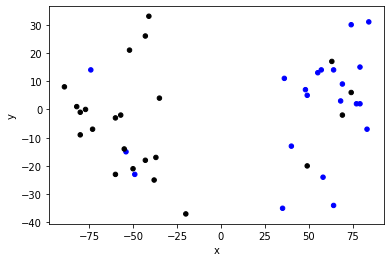

In [7]:
# generate sample plots to ensure shot location transformations are correct
df_tmp = df_shots[df_shots['time'] < 1200] # 1st period
# df_tmp = df_shots[(df_shots['time'] > 1200) & (df_shots['time'] < 2400)] # 2nd period
# df_tmp = df_shots[(df_shots['time'] > 2400) & (df_shots['time'] < 3600)] # 2nd period

df_tmp['color'] = np.where(df_tmp['teamId']==3, 'blue', 'black')


df_tmp.plot.scatter(x='x', y='y',c='color')

### Retrieve Time on Ice data

Start by retrieving data from api

In [8]:
def calc_gametime_second(period, time):
    time_in_seconds = int(time[:2]) * 60 + int(time[3:])
    return (period - 1) * 1200 + time_in_seconds

def extract_json_shifts(d):
    return [{
        'gameId': shift['gameId'],
        'teamId': shift['teamId'],
        'playerId': shift['playerId'],
        'start': calc_gametime_second(shift['period'], shift['startTime']),
        'end': calc_gametime_second(shift['period'], shift['endTime'])
    } for shift in d['data']]

In [9]:
all_shifts = []
try:
    # get data for this game_id
    r = requests.get(url=f'https://api.nhle.com/stats/rest/en/shiftcharts?cayenneExp=gameId={gameId}')
    d = r.json()

    # extract shift data
    all_shifts.extend(extract_json_shifts(d))

except:
    print('could not fetch gameId: ' + gameId)

In [10]:
# convert to df
df_shifts = pd.DataFrame(all_shifts)

# some shifts are recorded with identical start/end times, omit these rows
df_shifts = df_shifts[df_shifts['start'] != df_shifts['end']]

# sort df
df_shifts = df_shifts.sort_values(['gameId', 'teamId', 'start', 'end', 'playerId'])
df_shifts.head(10)

,gameId,teamId,playerId,start,end
319,2021030143,3,8476885,0,34
726,2021030143,3,8480817,0,35
265,2021030143,3,8476459,0,41
568,2021030143,3,8478366,0,42
151,2021030143,3,8475184,0,43
556,2021030143,3,8478048,0,1200
675,2021030143,3,8479323,34,71
126,2021030143,3,8474027,35,70
635,2021030143,3,8478550,41,80
244,2021030143,3,8476458,42,80


In [11]:
# convert back to dict so we can identify line combinations
shifts = df_shifts.to_dict(orient='records')
shifts[0]

{'gameId': 2021030143, 'teamId': 3, 'playerId': 8476885, 'start': 0, 'end': 34}

##### Then group players by line

In [12]:
def line_list_to_shift(line_list, start, end):
    # need this for when dataset changes from teamId_1 to teamId_2
    # ...corrects end time of final shift 'first' team's shift data
    if end <= start:
        end = line_list[0]['end']
    return {
        'playerIds': [player['playerId'] for player in line_list],
        'start': start,
        'end': end,
        'numPlayers': len(line_list),
        'teamId': line_list[0]['teamId']
    }

def next_shift_end(line_list):
    return min([player['end'] for player in line_list])

In [13]:
# get starting lines
start_time = shifts[0]['start']
line_list = []
line_shifts = []
i = 0

while i < len(shifts)-1: #and shifts[i]['teamId'] == 6:
    # add players starting shift
    while start_time == shifts[i]['start']:
        line_list.append(shifts[i])
        i += 1
        if i == len(shifts):
            i -= 1 # at the end of shifts data for this game
            break
    
    # figure out the time when the next player is getting on/off the ice
    next_player_off = next_shift_end(line_list)
    next_player_on = shifts[i]['start']
    end_time = min([next_player_off, next_player_on])

    # new player getting on, save this line combination
    line_shifts.append(line_list_to_shift(line_list, start_time, end_time))

    # cut list to only contain players that remain on the ice after end_time
    line_list = [player for player in line_list if player['end'] > end_time]
    
    # if reached end of shifts for this game for this team, clear line_list
    if next_player_on == 0:
        line_list = []

    # update start_time with time that new player(s) are getting on the ice
    start_time = end_time

In [14]:
pd.DataFrame(line_shifts)

,playerIds,start,end,numPlayers,teamId
0,"[8476885, 8480817, 8476459, 8478366, 8475184, ...",0,34,6,3
1,"[8480817, 8476459, 8478366, 8475184, 8478048, ...",34,35,6,3
2,"[8476459, 8478366, 8475184, 8478048, 8479323, ...",35,41,6,3
3,"[8478366, 8475184, 8478048, 8479323, 8474027, ...",41,42,6,3
4,"[8475184, 8478048, 8479323, 8474027, 8478550, ...",42,43,6,3
...,...,...,...,...,...
474,"[8475839, 8471724, 8476875, 8470604, 8476934, ...",3496,3529,6,5
475,"[8475839, 8471724, 8470604, 8476934, 8471675, ...",3529,3533,6,5
476,"[8475839, 8475722, 8470619, 8476927, 8477244, ...",3533,3567,6,5
477,"[8475839, 8470619, 8476927, 8477244, 8478017, ...",3567,3568,6,5


##### Next compute the num players on the ice for each team

This will help with calculating scenarios in SQL queries (e.g., 5on5 or 5on4)

In [15]:
away_shifts = [s for s in line_shifts if s['teamId']==awayTeamId]
away_shifts_frames = []
for s in away_shifts:
    for i in range(s['start'], s['end']):
        away_shifts_frames.append({
            'awayPlayerIds': s['playerIds'],
            'time': i
        })
        
home_shifts = [s for s in line_shifts if s['teamId']==homeTeamId]
home_shifts_frames = []
for s in home_shifts:
    for i in range(s['start'], s['end']):
        home_shifts_frames.append({
            'homePlayerIds': s['playerIds'],
            'time': i
        })

In [16]:
df = pd.DataFrame(away_shifts_frames).merge(pd.DataFrame(home_shifts_frames), on='time')
df = df[['time', 'awayPlayerIds', 'homePlayerIds']]
df['awayNumPlayers'] = df['awayPlayerIds'].str.len()
df['homeNumPlayers'] = df['homePlayerIds'].str.len()
df

,time,awayPlayerIds,homePlayerIds,awayNumPlayers,homeNumPlayers
0,0,"[8476885, 8480817, 8476459, 8478366, 8475184, ...","[8477404, 8471675, 8475810, 8476875, 8471724, ...",6,6
1,1,"[8476885, 8480817, 8476459, 8478366, 8475184, ...","[8477404, 8471675, 8475810, 8476875, 8471724, ...",6,6
2,2,"[8476885, 8480817, 8476459, 8478366, 8475184, ...","[8477404, 8471675, 8475810, 8476875, 8471724, ...",6,6
3,3,"[8476885, 8480817, 8476459, 8478366, 8475184, ...","[8477404, 8471675, 8475810, 8476875, 8471724, ...",6,6
4,4,"[8476885, 8480817, 8476459, 8478366, 8475184, ...","[8477404, 8471675, 8475810, 8476875, 8471724, ...",6,6
...,...,...,...,...,...
3595,3595,"[8475747, 8478211, 8478366, 8479291, 8480382, ...","[8475839, 8477244, 8478017, 8478046, 8477953, ...",6,6
3596,3596,"[8475747, 8478211, 8478366, 8479291, 8480382, ...","[8475839, 8477244, 8478017, 8478046, 8477953, ...",6,6
3597,3597,"[8475747, 8478211, 8478366, 8479291, 8480382, ...","[8475839, 8477244, 8478017, 8478046, 8477953, ...",6,6
3598,3598,"[8475747, 8478211, 8478366, 8479291, 8480382, ...","[8475839, 8477244, 8478017, 8478046, 8477953, ...",6,6


##### Separate playerIds by position
make columns for fwd/def/goalie and serialize data (i.e., [8476885, 8480817, 8476459] -> '8476885_8480817_8476459')

In [17]:
df['awayPlayerIds'][0]

[8476885, 8480817, 8476459, 8478366, 8475184, 8478048]

In [18]:
timeframes = df.to_dict(orient='records')

In [19]:
def serialize_ids(playerIds):
    return '_'.join(str(i) for i in sorted(playerIds))

In [20]:
serialized_shifts = []
for t in timeframes:
    serialized_shifts.append({
        'gameId': gameId,
        'time': t['time'],
        'awayNumPlayers': t['awayNumPlayers'],
        'awayFwdIds': serialize_ids([playerId for playerId in t['awayPlayerIds'] if playerId in forwards]),
        'awayDefIds': serialize_ids([playerId for playerId in t['awayPlayerIds'] if playerId in defensemen]),
        'awayGoalieIds': serialize_ids([playerId for playerId in t['awayPlayerIds'] if playerId in goalies]),
        'homeFwdIds': serialize_ids([playerId for playerId in t['homePlayerIds'] if playerId in forwards]),
        'homeDefIds': serialize_ids([playerId for playerId in t['homePlayerIds'] if playerId in defensemen]),
        'homeGoalieIds': serialize_ids([playerId for playerId in t['homePlayerIds'] if playerId in goalies]),
        'homeNumPlayers': t['homeNumPlayers']
    })

In [21]:
df = pd.DataFrame(serialized_shifts)
df.head()

,gameId,time,awayNumPlayers,awayFwdIds,awayDefIds,awayGoalieIds,homeFwdIds,homeDefIds,homeGoalieIds,homeNumPlayers
0,2021030143,0,6,8475184_8476459_8478366,8476885_8480817,8478048,8471675_8475810_8477404,8471724_8476875,8475839,6
1,2021030143,1,6,8475184_8476459_8478366,8476885_8480817,8478048,8471675_8475810_8477404,8471724_8476875,8475839,6
2,2021030143,2,6,8475184_8476459_8478366,8476885_8480817,8478048,8471675_8475810_8477404,8471724_8476875,8475839,6
3,2021030143,3,6,8475184_8476459_8478366,8476885_8480817,8478048,8471675_8475810_8477404,8471724_8476875,8475839,6
4,2021030143,4,6,8475184_8476459_8478366,8476885_8480817,8478048,8471675_8475810_8477404,8471724_8476875,8475839,6


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gameId          3600 non-null   int64 
 1   time            3600 non-null   int64 
 2   awayNumPlayers  3600 non-null   int64 
 3   awayFwdIds      3600 non-null   object
 4   awayDefIds      3600 non-null   object
 5   awayGoalieIds   3600 non-null   object
 6   homeFwdIds      3600 non-null   object
 7   homeDefIds      3600 non-null   object
 8   homeGoalieIds   3600 non-null   object
 9   homeNumPlayers  3600 non-null   int64 
dtypes: int64(4), object(6)
memory usage: 281.4+ KB


### Create minutes df

In [23]:
# compute scenario of each timeframe
numHome = df['homeNumPlayers']
numAway = df['awayNumPlayers']
df['scenario'] = np.where((numHome==6) & (numAway==6), '5on5',
                         np.where((numHome==6) & (numAway==5), '5on4',
                                 np.where((numHome==5) & (numAway==6), '5on4',
                                         np.where((numHome==5) & (numAway==5), '4on4',
                                                 np.where((numHome==5) & (numAway==4), '4on3',
                                                         np.where((numHome==4) & (numAway==5), '4on3', '3on3')
                                                         )
                                                 )
                                         )
                                 )
                         )
df['scenario'] = np.where((df['awayGoalieIds'].str.len()<7) | (df['homeGoalieIds'].str.len()<7), 
                          'emptyNet', 
                          df['scenario'])
df

,gameId,time,awayNumPlayers,awayFwdIds,awayDefIds,awayGoalieIds,homeFwdIds,homeDefIds,homeGoalieIds,homeNumPlayers,scenario
0,2021030143,0,6,8475184_8476459_8478366,8476885_8480817,8478048,8471675_8475810_8477404,8471724_8476875,8475839,6,5on5
1,2021030143,1,6,8475184_8476459_8478366,8476885_8480817,8478048,8471675_8475810_8477404,8471724_8476875,8475839,6,5on5
2,2021030143,2,6,8475184_8476459_8478366,8476885_8480817,8478048,8471675_8475810_8477404,8471724_8476875,8475839,6,5on5
3,2021030143,3,6,8475184_8476459_8478366,8476885_8480817,8478048,8471675_8475810_8477404,8471724_8476875,8475839,6,5on5
4,2021030143,4,6,8475184_8476459_8478366,8476885_8480817,8478048,8471675_8475810_8477404,8471724_8476875,8475839,6,5on5
...,...,...,...,...,...,...,...,...,...,...,...
3595,2021030143,3595,6,8478211_8478366_8479291,8475747_8482073,8480382,8477953_8478046_8478542,8477244_8478017,8475839,6,5on5
3596,2021030143,3596,6,8478211_8478366_8479291,8475747_8482073,8480382,8477953_8478046_8478542,8477244_8478017,8475839,6,5on5
3597,2021030143,3597,6,8478211_8478366_8479291,8475747_8482073,8480382,8477953_8478046_8478542,8477244_8478017,8475839,6,5on5
3598,2021030143,3598,6,8478211_8478366_8479291,8475747_8482073,8480382,8477953_8478046_8478542,8477244_8478017,8475839,6,5on5


In [24]:
df[df['scenario']=='emptyNet']

,gameId,time,awayNumPlayers,awayFwdIds,awayDefIds,awayGoalieIds,homeFwdIds,homeDefIds,homeGoalieIds,homeNumPlayers,scenario
2103,2021030143,2103,6,8476458_8477429_8478550,8479323_8482073,8480382,8470619_8476927_8478542,8471724_8476875_8477969,,6,emptyNet
2104,2021030143,2104,6,8476459_8477429_8478550,8479323_8482073,8480382,8470619_8471675_8476927_8478542,8471724_8476875,,6,emptyNet
2105,2021030143,2105,6,8476459_8477429_8478550,8479323_8482073,8480382,8471215_8471675_8477404_8478542,8471724_8476875,,6,emptyNet
2106,2021030143,2106,6,8476459_8477429_8478550,8479323_8482073,8480382,8471215_8471675_8477404_8478542,8471724_8476875,,6,emptyNet
2107,2021030143,2107,6,8476459_8477429_8478550,8479323_8482073,8480382,8471215_8471675_8477404_8478542,8471724_8476875,,6,emptyNet
...,...,...,...,...,...,...,...,...,...,...,...
3528,2021030143,3528,6,8478550_8480078_8481554_8482109,8474027_8479323,,8470604_8471675_8476934,8471724_8476875,8475839,6,emptyNet
3529,2021030143,3529,6,8478550_8480078_8481554_8482109,8474027_8479323,,8470604_8471675_8476934,8471724_8478507,8475839,6,emptyNet
3530,2021030143,3530,6,8478550_8480078_8481554_8482109,8474027_8479323,,8470604_8471675_8476934,8471724_8478507,8475839,6,emptyNet
3531,2021030143,3531,6,8478550_8480078_8481554_8482109,8474027_8479323,,8470604_8471675_8476934,8471724_8478507,8475839,6,emptyNet


In [25]:
df[['time', 'awayFwdIds', 'scenario']]

,time,awayFwdIds,scenario
0,0,8475184_8476459_8478366,5on5
1,1,8475184_8476459_8478366,5on5
2,2,8475184_8476459_8478366,5on5
3,3,8475184_8476459_8478366,5on5
4,4,8475184_8476459_8478366,5on5
...,...,...,...
3595,3595,8478211_8478366_8479291,5on5
3596,3596,8478211_8478366_8479291,5on5
3597,3597,8478211_8478366_8479291,5on5
3598,3598,8478211_8478366_8479291,5on5


In [26]:
timeframes = df.to_dict(orient='records')
timeframes[0]

{'gameId': 2021030143,
 'time': 0,
 'awayNumPlayers': 6,
 'awayFwdIds': '8475184_8476459_8478366',
 'awayDefIds': '8476885_8480817',
 'awayGoalieIds': '8478048',
 'homeFwdIds': '8471675_8475810_8477404',
 'homeDefIds': '8471724_8476875',
 'homeGoalieIds': '8475839',
 'homeNumPlayers': 6,
 'scenario': '5on5'}

In [71]:
shifts = []
homeTeamId = 5
awayTeamId = 3
cats = ['awayFwdIds', 'awayDefIds', 'awayGoalieIds',
       'homeFwdIds', 'homeDefIds', 'homeGoalieIds']

for cat in cats:
    teamId = homeTeamId
    if 'away' in cat:
        teamId = awayTeamId
    lineType = 'fwd'
    if 'Def' in cat:
        lineType = 'def'
    elif 'Goalie' in cat:
        lineType = 'goalie'
        
    start = 0
    cur_line = timeframes[0][cat]
    cur_scenario = timeframes[0]['scenario']

    for i in range(1,len(timeframes)):
        if timeframes[i][cat] != cur_line or timeframes[i]['scenario'] != cur_scenario:
            if cur_line != '':
                shifts.append({
                    'start': start,
                    'end': i,
                    'duration': i-start,
                    'gameId': gameId,
                    'teamId': teamId,
                    'lineId': cur_line,
                    'lineType': lineType,
                    'scenario': cur_scenario
                })

            start = i
            cur_line = timeframes[i][cat]
            cur_scenario = timeframes[i]['scenario']
    shifts.append({
        'start': start,
        'end': i,
        'duration': i-start,
        'gameId': gameId,
        'teamId': teamId,
        'lineId': cur_line,
        'lineType': lineType,
        'scenario': cur_scenario
    })

In [72]:
df_shifts = pd.DataFrame(shifts)

In [74]:
df_shifts.sort_values(['end', 'start'], ascending=False)

,start,end,duration,gameId,teamId,lineId,lineType,scenario
502,3568,3599,31,2021030143,5,8477953_8478046_8478542,fwd,5on5
158,3533,3599,66,2021030143,3,8478211_8478366_8479291,fwd,5on5
291,3533,3599,66,2021030143,3,8475747_8482073,def,5on5
308,3533,3599,66,2021030143,3,8480382,goalie,5on5
640,3533,3599,66,2021030143,5,8477244_8478017,def,5on5
...,...,...,...,...,...,...,...,...
310,35,42,7,2021030143,5,8471675_8475810_8478046,fwd,5on5
0,0,41,41,2021030143,3,8475184_8476459_8478366,fwd,5on5
160,34,35,1,2021030143,3,8479323_8480817,def,5on5
309,0,35,35,2021030143,5,8471675_8475810_8477404,fwd,5on5


In [30]:
df_shifts[(df_shifts['teamId']==3) & (df_shifts['lineType']=='fwd')]

,start,end,duration,teamId,lineId,lineType,scenario
0,0,41,41,3,8475184_8476459_8478366,fwd,5on5
1,41,42,1,3,8475184_8478366_8478550,fwd,5on5
2,42,43,1,3,8475184_8476458_8478550,fwd,5on5
3,43,80,37,3,8476458_8477429_8478550,fwd,5on5
4,80,117,37,3,8480078_8481554_8482109,fwd,5on5
...,...,...,...,...,...,...,...
154,3439,3456,17,3,8475184_8476459_8478366,fwd,5on5
155,3456,3466,10,3,8475184_8476458_8476459_8477429_8478550,fwd,emptyNet
156,3466,3480,14,3,8480078_8481554_8482109,fwd,5on5
157,3480,3533,53,3,8478550_8480078_8481554_8482109,fwd,emptyNet


In [31]:
df_shifts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658 entries, 0 to 657
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   start     658 non-null    int64 
 1   end       658 non-null    int64 
 2   duration  658 non-null    int64 
 3   teamId    658 non-null    int64 
 4   lineId    658 non-null    object
 5   lineType  658 non-null    object
 6   scenario  658 non-null    object
dtypes: int64(4), object(3)
memory usage: 36.1+ KB


### Merge shot and timeframe df

In [32]:
df_shot_players = df_shots.merge(df, on='time')
df_shot_players

,shooterId,goalieId,blockerId,teamId,x,y,time,type,gameId,awayNumPlayers,awayFwdIds,awayDefIds,awayGoalieIds,homeFwdIds,homeDefIds,homeGoalieIds,homeNumPlayers,scenario
0,8475810,8478048,0,5,-52.0,21.0,27,SHOT,2021030143,6,8475184_8476459_8478366,8476885_8480817,8478048,8471675_8475810_8477404,8471724_8476875,8475839,6,5on5
1,8476458,8475839,0,3,79.0,15.0,79,SHOT,2021030143,6,8476458_8477429_8478550,8475747_8482073,8478048,8471215_8477953_8478046,8477969_8478507,8475839,6,5on5
2,8481554,8475839,0,3,74.0,30.0,85,SHOT,2021030143,6,8480078_8481554_8482109,8475747_8482073,8478048,8470604_8475722_8476934,8477244_8478017,8475839,6,5on5
3,8482109,0,0,3,83.0,-7.0,87,MISSED_SHOT,2021030143,6,8480078_8481554_8482109,8475747_8482073,8478048,8470604_8475722_8476934,8477244_8478017,8475839,6,5on5
4,8476934,8478048,0,5,-89.0,8.0,117,GOAL,2021030143,6,8471817_8478211_8479291,8476885_8480817,8478048,8470619_8476927_8478542,8471724_8476875,8475839,6,5on5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,8478550,0,8471724,5,72.0,-8.0,3462,BLOCKED_SHOT,2021030143,6,8475184_8476458_8476459_8477429_8478550,8479323,,8471675_8475810_8477404,8471724_8476875,8475839,6,emptyNet
126,8477404,0,0,5,31.0,-38.0,3466,GOAL,2021030143,6,8480078_8481554_8482109,8474027_8479323,8480382,8470604_8476927_8476934,8471724_8476875,8475839,6,5on5
127,8478550,8475839,0,3,53.0,35.0,3519,SHOT,2021030143,6,8478550_8480078_8481554_8482109,8474027_8479323,,8470604_8471675_8476934,8471724_8476875,8475839,6,emptyNet
128,8476934,0,0,5,-38.0,-23.0,3532,MISSED_SHOT,2021030143,6,8478550_8480078_8481554_8482109,8474027_8479323,,8470604_8471675_8476934,8471724_8478507,8475839,6,emptyNet


## Example of getting Data from datasets

In [43]:
line_str = '8477969_8478507'
mp = df_shifts[df_shifts['lineId']==line_str]['duration'].sum() / 60

In [44]:
tid = 5
# cf = len(df_shot_players[(df_shot_players['awayFwdIds']==line_str) & (df_shot_players['teamId']==tid)])
# ca = len(df_shot_players[(df_shot_players['awayFwdIds']==line_str) & (df_shot_players['teamId']!=tid)])

cf = len(df_shot_players[(df_shot_players['homeDefIds']==line_str) & (df_shot_players['teamId']==tid)])
ca = len(df_shot_players[(df_shot_players['homeDefIds']==line_str) & (df_shot_players['teamId']!=tid)])
cr = cf - ca

In [45]:
df_shot_players[(df_shot_players['homeDefIds']==line_str)]

,shooterId,goalieId,blockerId,teamId,x,y,time,type,gameId,awayNumPlayers,awayFwdIds,awayDefIds,awayGoalieIds,homeFwdIds,homeDefIds,homeGoalieIds,homeNumPlayers,scenario
1,8476458,8475839,0,3,79.0,15.0,79,SHOT,2021030143,6,8476458_8477429_8478550,8475747_8482073,8478048,8471215_8477953_8478046,8477969_8478507,8475839,6,5on5
19,8470604,8478048,0,5,-82.0,1.0,498,GOAL,2021030143,6,8476458_8477429_8478550,8475747_8482073,8478048,8475722_8476927_8476934,8477969_8478507,8475839,6,5on5
20,8475722,8478048,0,5,-80.0,-9.0,534,SHOT,2021030143,6,8476458_8477429_8478550,8474027_8479323,8478048,8475722_8476927_8476934,8477969_8478507,8475839,6,5on5
23,8478542,8478048,0,5,-77.0,-0.0,631,GOAL,2021030143,6,8471817_8478211_8479291,8475747_8482073,8478048,8475722_8476927_8476934,8477969_8478507,8475839,6,5on5
24,8477969,0,8479291,3,-54.0,-15.0,662,BLOCKED_SHOT,2021030143,6,8471817_8478211_8479291,8475747_8482073,8478048,8475722_8476927_8476934,8477969_8478507,8475839,6,5on5
30,8478542,8478048,0,5,-60.0,-3.0,915,GOAL,2021030143,6,8471817_8478211_8479291,8474027_8479323,8478048,8470619_8476927_8478542,8477969_8478507,8475839,6,5on5
35,8477969,0,8478366,3,-49.0,-23.0,1049,BLOCKED_SHOT,2021030143,6,8475184_8476459_8478366,8475747_8476885,8478048,8471675_8475810_8477404,8477969_8478507,8475839,6,5on5
36,8478366,0,0,3,55.0,13.0,1059,MISSED_SHOT,2021030143,6,8475184_8478366_8480078,8475747_8482073,8478048,8471675_8477404_8477953,8477969_8478507,8475839,6,5on5
38,8475722,8478048,0,5,-37.0,-17.0,1156,SHOT,2021030143,6,8476458_8477429_8478550,8476885_8480817,8478048,8470604_8475722_8476934,8477969_8478507,8475839,6,5on5
42,8477953,0,0,5,-55.0,-14.0,1194,MISSED_SHOT,2021030143,6,8475184_8476459_8478366,8475747_8482073,8478048,8470604_8471215_8477953,8477969_8478507,8475839,6,5on5


In [46]:
print('minutes played: ' + str(mp))
print('corsi for: ' + str(cf))
print('corsi against: ' + str(ca))
print('corsi relative: ' + str(cr))

minutes played: 13.416666666666666
corsi for: 16
corsi against: 15
corsi relative: 1


In [47]:
df_shot_players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130 entries, 0 to 129
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   shooterId       130 non-null    int64  
 1   goalieId        130 non-null    int64  
 2   blockerId       130 non-null    int64  
 3   teamId          130 non-null    int64  
 4   x               130 non-null    float64
 5   y               130 non-null    float64
 6   time            130 non-null    int64  
 7   type            130 non-null    object 
 8   gameId          130 non-null    int64  
 9   awayNumPlayers  130 non-null    int64  
 10  awayFwdIds      130 non-null    object 
 11  awayDefIds      130 non-null    object 
 12  awayGoalieIds   130 non-null    object 
 13  homeFwdIds      130 non-null    object 
 14  homeDefIds      130 non-null    object 
 15  homeGoalieIds   130 non-null    object 
 16  homeNumPlayers  130 non-null    int64  
 17  scenario        130 non-null    obj

In [48]:
# df_tmp = df_shot_players[['shooterId', 'gameId']].copy()
# df_tmp['shotId'] = [i for i in range(0, len(df_tmp))]
# df_tmp

In [52]:
# df_shot_players.to_dict(orient='records')
df_shot_players.to_csv('data/shotSample.csv', index=False)

In [ ]:
# with open('data/shotSample.json') as f:
#     shot_data = 

In [67]:
# df_t = pd.read_json('data/shotSample.json')
df_t = pd.read_json('data/shotSample.json', dtype={
    'awayFwdIds': 'str',
    'awayDefIds': 'str',
    'awayGoalieIds': 'str',
    'homeFwdIds': 'str',
    'homeDefIds': 'str',
    'homeGoalieIds': 'str',
})#.fillna('')
# df_t.fillna('')
# df_t['awayGoalieIds'] = df_t['awayGoalieIds'].astype(str)
df_t

,shooterId,goalieId,blockerId,teamId,x,y,time,type,gameId,awayNumPlayers,awayFwdIds,awayDefIds,awayGoalieIds,homeFwdIds,homeDefIds,homeGoalieIds,homeNumPlayers,scenario
0,8475810,8478048,0,5,-52,21,27,SHOT,2021030143,6,8475184_8476459_8478366,8476885_8480817,8478048,8471675_8475810_8477404,8471724_8476875,8475839,6,5on5
1,8476458,8475839,0,3,79,15,79,SHOT,2021030143,6,8476458_8477429_8478550,8475747_8482073,8478048,8471215_8477953_8478046,8477969_8478507,8475839,6,5on5
2,8481554,8475839,0,3,74,30,85,SHOT,2021030143,6,8480078_8481554_8482109,8475747_8482073,8478048,8470604_8475722_8476934,8477244_8478017,8475839,6,5on5
3,8482109,0,0,3,83,-7,87,MISSED_SHOT,2021030143,6,8480078_8481554_8482109,8475747_8482073,8478048,8470604_8475722_8476934,8477244_8478017,8475839,6,5on5
4,8476934,8478048,0,5,-89,8,117,GOAL,2021030143,6,8471817_8478211_8479291,8476885_8480817,8478048,8470619_8476927_8478542,8471724_8476875,8475839,6,5on5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,8478550,0,8471724,5,72,-8,3462,BLOCKED_SHOT,2021030143,6,8475184_8476458_8476459_8477429_8478550,8479323,,8471675_8475810_8477404,8471724_8476875,8475839,6,emptyNet
126,8477404,0,0,5,31,-38,3466,GOAL,2021030143,6,8480078_8481554_8482109,8474027_8479323,8480382,8470604_8476927_8476934,8471724_8476875,8475839,6,5on5
127,8478550,8475839,0,3,53,35,3519,SHOT,2021030143,6,8478550_8480078_8481554_8482109,8474027_8479323,,8470604_8471675_8476934,8471724_8476875,8475839,6,emptyNet
128,8476934,0,0,5,-38,-23,3532,MISSED_SHOT,2021030143,6,8478550_8480078_8481554_8482109,8474027_8479323,,8470604_8471675_8476934,8471724_8478507,8475839,6,emptyNet


In [60]:
df_t['awayGoalieIds'].fillna('').astype(str)

0      8478048.0
1      8478048.0
2      8478048.0
3      8478048.0
4      8478048.0
         ...    
125             
126    8480382.0
127             
128             
129    8480382.0
Name: awayGoalieIds, Length: 130, dtype: object

In [42]:
df_t['awayDefIds']

0      84768858480817
1      84757478482073
2      84757478482073
3      84757478482073
4      84768858480817
            ...      
125           8479323
126    84740278479323
127    84740278479323
128    84740278479323
129    84757478482073
Name: awayDefIds, Length: 130, dtype: int64

##### Save shift data to file

In [75]:
df_shifts

,start,end,duration,gameId,teamId,lineId,lineType,scenario
0,0,41,41,2021030143,3,8475184_8476459_8478366,fwd,5on5
1,41,42,1,2021030143,3,8475184_8478366_8478550,fwd,5on5
2,42,43,1,2021030143,3,8475184_8476458_8478550,fwd,5on5
3,43,80,37,2021030143,3,8476458_8477429_8478550,fwd,5on5
4,80,117,37,2021030143,3,8480078_8481554_8482109,fwd,5on5
...,...,...,...,...,...,...,...,...
653,2909,3456,547,2021030143,5,8475839,goalie,5on5
654,3456,3466,10,2021030143,5,8475839,goalie,emptyNet
655,3466,3480,14,2021030143,5,8475839,goalie,5on5
656,3480,3533,53,2021030143,5,8475839,goalie,emptyNet


In [76]:
df_shifts.to_json('data/shiftSample.json', orient='records')

In [82]:
df_t = pd.read_json('data/shiftSample.json', dtype={
    'lineId': 'str'
})
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658 entries, 0 to 657
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   start     658 non-null    int64 
 1   end       658 non-null    int64 
 2   duration  658 non-null    int64 
 3   gameId    658 non-null    int64 
 4   teamId    658 non-null    int64 
 5   lineId    658 non-null    object
 6   lineType  658 non-null    object
 7   scenario  658 non-null    object
dtypes: int64(5), object(3)
memory usage: 41.2+ KB


##### Save roster data

In [137]:
df_roster = pd.DataFrame(roster)
df_roster['height'] = df_roster['height'].str[:1].astype(int)*12 + df_roster['height'].str[3:-1].astype(int)
df_roster.to_json('data/rosterSample.json', orient='records')

In [140]:
df_t = pd.read_json('data/rosterSample.json')
# df_t

##### Save schedule data

In [174]:
gameInfo
gameInfo2 = [
    {'gameId': 2021030143,
     'dateTime': '2022-05-07T23:00:00Z',
     'awayTeamId': 3,
     'homeTeamId': 5},
    {'gameId': 2021030147,
    'dateTime': '2022-05-09T23:00:00Z',
    'awayTeamId': 5,
    'homeTeamId': 3}
]
gameInfo2

[{'gameId': 2021030143,
  'dateTime': '2022-05-07T23:00:00Z',
  'awayTeamId': 3,
  'homeTeamId': 5},
 {'gameId': 2021030147,
  'dateTime': '2022-05-09T23:00:00Z',
  'awayTeamId': 5,
  'homeTeamId': 3}]

In [175]:
df_schedule = pd.DataFrame(gameInfo2)
df_schedule.to_json('data/scheduleSample.json', orient='records')

In [176]:
df_t = pd.read_json('data/scheduleSample.json')
df_t

,gameId,dateTime,awayTeamId,homeTeamId
0,2021030143,2022-05-07 23:00:00+00:00,3,5
1,2021030147,2022-05-09 23:00:00+00:00,5,3


##### Save teams data

In [189]:
df_teams = pd.DataFrame(teams)
df_teams.to_json('data/teamsSample.json', orient='records')

In [192]:
df_t = pd.read_json('data/teamsSample.json')
df_t.columns

Index(['teamId', 'name', 'locationName', 'teamName', 'abbreviation',
       'division', 'conference', 'firstYearOfPlay', 'venue', 'timezone'],
      dtype='object')